In [1]:
import matplotlib.pyplot as plt
import sxs
import numpy as np
import astropy.units as u
from scipy.special import roots_legendre, sph_harm
from scipy.integrate import simpson
from matplotlib.colors import LogNorm
import qnm
import scri
import quaternion

In [2]:
plt.rcParams['axes.labelsize']=12
plt.rcParams['axes.titlesize']=12

In [3]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

# Load and Rotate SpEC data

In [4]:
spectra_rot = []
spectra = []
spectra_rot_p = []
remnant_spin_amps = []
theta_offsets = []
phi_offsets = []
mass_ratios = []
catalog_names = []
plunging_thetas = []
plunging_phis = []
mis_angs = []
failed_names = []
times = []
remnant_masses = []
deltaJs = []
deltaJ_mis_angles = []
eccentricities = []
Jdot_mis_angles = []
for i in range(200,201):#2300):
    try:
        waveform = sxs.load("SXS:BBH:%04d/Lev/rhOverM"%i, extrapolation_order=4)
        metadata = sxs.load("SXS:BBH:%04d/Lev/metadata.json"%i)
        horizons = sxs.load("SXS:BBH:%04d/Lev/Horizons.h5"%i)
        data = waveform.data
        t = waveform.t
        
        #eccentricity 
        eccentricity = metadata.reference_eccentricity
        if type(eccentricity)==str:
            eccentricity = float(eccentricity[1:])

        # Velocity of the two holes and plunging angle
        vA = np.array(horizons.A.coord_center_inertial[-1]-horizons.A.coord_center_inertial[-2])[0]
        vB = np.array(horizons.B.coord_center_inertial[-1]-horizons.B.coord_center_inertial[-2])[0]
        massA = metadata.initial_mass1
        massB = metadata.initial_mass2

        # normal for the plane of plunging
        normal = np.cross(vA,vB)
        plunging_theta = np.arccos(np.abs(normal[-1])/np.sqrt(np.sum(normal**2)))
        plunging_phi = np.arctan2(normal[1],normal[0])

        xA = np.array(horizons.A.coord_center_inertial[-1])[0]
        xB = np.array(horizons.B.coord_center_inertial[-1])[0]
        # define the plunging location in the frame of the more massive hole
        if massA >= massB:
            xdiff = xB-xA
        else:
            xdiff = xA-xB

        # save data after peak strain
        #tmax = horizons.C.time[0]
        total_waveform = np.sum(np.abs(waveform.data),axis=1)
        tmax = waveform.t[total_waveform==total_waveform[waveform.t>=300].max()][0]

        # Angular spectrum in orbital frame at and beyond peak strain
        spectrum = waveform.data[waveform.t>=tmax] #[0]
        spectrum_rot = np.array(spectrum)
        time = waveform.t[waveform.t>=tmax]

        # remnant dimensionless spin vector
        rem_spin = np.array(metadata.remnant_dimensionless_spin)
        # remnant spin axis angle
        theta_offset = np.arctan2(np.sqrt(rem_spin[0]**2+rem_spin[1]**2),rem_spin[2])
        phi_offset = np.arctan2(rem_spin[1],rem_spin[0])

        # spin amplitude
        remnant_spin_amp = np.sqrt(np.sum(rem_spin**2))


        h = scri.WaveformModes(
            dataType = scri.h,
            t = time,
            data = spectrum_rot,
            ell_min = 2,
            ell_max = 8,
            frameType = scri.Inertial,
            r_is_scaled_out = True,
            m_is_scaled_out = True
            )
        Jdot = scri.flux.angular_momentum_flux(h)

        deltaJ = []
        for j in range(3):
            deltaJ.append(simpson(Jdot[:,j], x=time))
        deltaJ = np.array(deltaJ)

        deltaJ_mis_angle = np.arccos(np.dot(rem_spin,deltaJ)/np.sqrt(np.dot(rem_spin,rem_spin)
                          *np.dot(deltaJ,deltaJ)))/np.pi*180
        
        # try using instantaneous flux to define the angle
        Jdot_inst = Jdot[0]
        
        Jdot_mis_angle = angle_between(Jdot_inst,rem_spin)

        # rotation
        R = quaternion.from_euler_angles(np.array([phi_offset,theta_offset,0]), beta=None, gamma=None)
        scri.rotations.rotate_decomposition_basis(h, R)
        # mass ratio
        mass_ratio = metadata.reference_mass_ratio

        # misalignment angle between remnant spin and plunging angle
        mis_ang = np.arccos(np.dot(normal,rem_spin)/np.sqrt(np.dot(normal,normal)\
                        *np.dot(rem_spin,rem_spin)))
        #print(remnant_spin_amp.shape)
        plunging_thetas.append(plunging_theta)
        plunging_phis.append(plunging_phi)
        remnant_spin_amps.append(remnant_spin_amp)
        theta_offsets.append(theta_offset)
        phi_offsets.append(np.mod(phi_offset,2*np.pi))
        mass_ratios.append(mass_ratio)
        times.append(time)
        spectra.append(spectrum)
        spectra_rot.append(spectrum_rot)
        #spectra_rot_p.append(spectrum_rot_p)
        mis_angs.append(mis_ang)
        remnant_masses.append(metadata.remnant_mass)
        catalog_names.append("SXS:BBH:%04d"%i)
        deltaJs.append(deltaJ)
        deltaJ_mis_angles.append(deltaJ_mis_angle)
        Jdot_mis_angles.append(Jdot_mis_angle)
        eccentricities.append(eccentricity)
    except:
        print("Error: SXS:BBH:%s Not Found!"%i )
        failed_names.append("SXS:BBH:%04d"%i)

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0200v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0200v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0200v5/Lev3/Horizons.h5


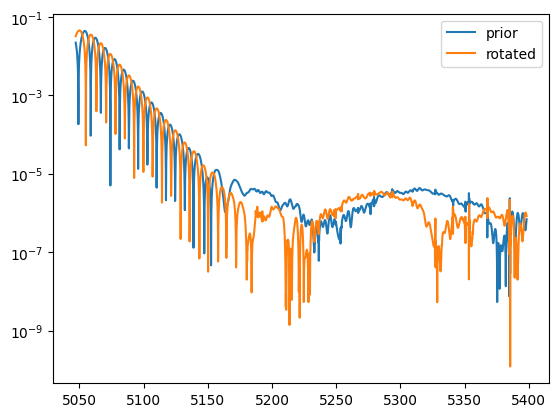

In [8]:
plt.plot(times[0],np.abs(spectra[0][:,1].real),label='prior')
plt.plot(times[0],np.abs(spectra_rot[0][:,1].real),label='rotated')

plt.yscale('log')
plt.legend()

In [9]:
times = np.array(times)
spectra = np.array(spectra)#,dtype=object)
spectra_rot = np.array(spectra_rot)#,dtype=object)
spectra_rot_p = np.array(spectra_rot_p)#,dtype=object)

remnant_masses = np.array(remnant_masses)
remnant_spin_amps = np.array(remnant_spin_amps)
theta_offsets = np.array(theta_offsets)
phi_offsets = np.array(phi_offsets)

mass_ratios = np.array(mass_ratios)
catalog_names = np.array(catalog_names)
mis_angs = np.array(mis_angs)
plunging_thetas = np.array(plunging_thetas)
plunging_phis = np.array(plunging_phis)

mis_angs[mis_angs>np.pi/2] = np.pi - mis_angs[mis_angs>np.pi/2]
deltaJs = np.array(deltaJs)
deltaJ_mis_angles=np.array(deltaJ_mis_angles)
Jdot_mis_angles=np.array(Jdot_mis_angles)

eccentricities = np.array(eccentricities)

/tmp/ipykernel_1372799/2137220152.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  times = np.array(times)
/tmp/ipykernel_1372799/2137220152.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spectra = np.array(spectra)#,dtype=object)
/tmp/ipykernel_1372799/2137220152.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spectra_r

In [10]:
np.savez('all_data_scri.npz',times=times, spectra=spectra, spectra_rot=spectra_rot, remnant_spin_amps= remnant_spin_amps,\
        theta_offsets=theta_offsets,phi_offsets=phi_offsets,mass_ratios=mass_ratios,catalog_names=catalog_names,\
        mis_angs=mis_angs,plunging_thetas=plunging_thetas,plunging_phis=plunging_phis,\
        remnant_masses=remnant_masses,deltaJ_mis_angles=deltaJ_mis_angles,deltaJs=deltaJs,\
        Jdot_mis_angles=Jdot_mis_angles,eccentricities=eccentricities)